In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob

#These are some matplot lib configurations that I like to use. 
mpl.rc("text", usetex=True) #if tou have Latex set this to true and matplotlib will render labels in latex
mpl.rc("font", family = "serif") #Serif font in matplotlib
mpl.rc("figure",figsize=(9,6)) #Increase default figure size
%config InlineBackend.figure_format = 'retina' #If you have a high res display, render the plots more nicely
mpl.style.use('dark_background') #use a dark background for matplotlib figures if youre using dark theme
plt.rcParams.update({"figure.facecolor": "111111",
                     "savefig.facecolor": "212121"})

In [2]:
import pyheif
from PIL import Image

In [15]:
heif_file = pyheif.read('/Users/johnrussell/Downloads/IMG_4536.HEIC')

In [8]:
imtest.size

(3024, 4032)

In [16]:
image = Image.frombytes(
    heif_file.mode, 
    heif_file.size, 
    heif_file.data,
    "raw",
    heif_file.mode,
    heif_file.stride,
    )

In [27]:
arr1 = np.array(image)

In [31]:
arr = np.frombuffer(heif_file.data, dtype='uint8')

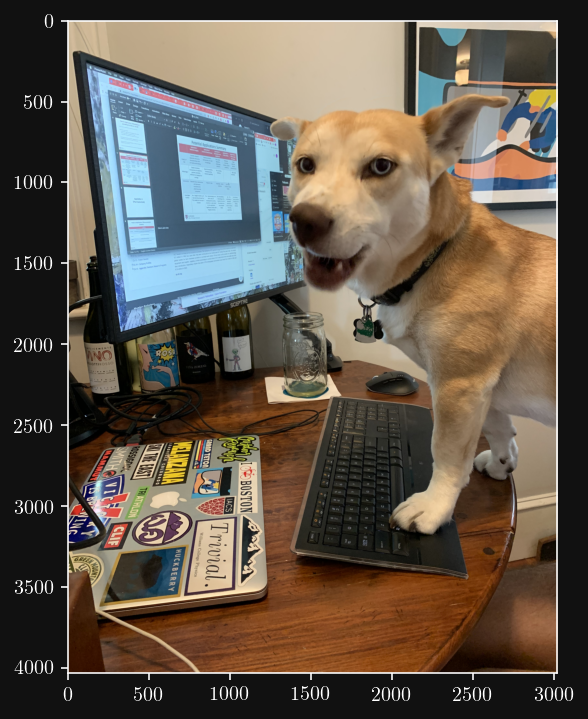

In [33]:
plt.imshow(arr.reshape(arr1.shape))
plt.show()

In [49]:
xi = torch.tensor([-1.], requires_grad=True)

In [50]:
yi = y(xi)

In [51]:
y(.backward()

In [52]:
xi.grad

tensor([96.])

In [48]:
dy(xi)

tensor([-8.], grad_fn=<AddBackward0>)

In [58]:
dydt = lambda y, mu, lam: mu*y**2*(1-y) - (lam+1)*y + lam

In [59]:
yplt = np.linspace(0,1,200)

In [60]:
np.logspace(-2, 2, 5)

array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])

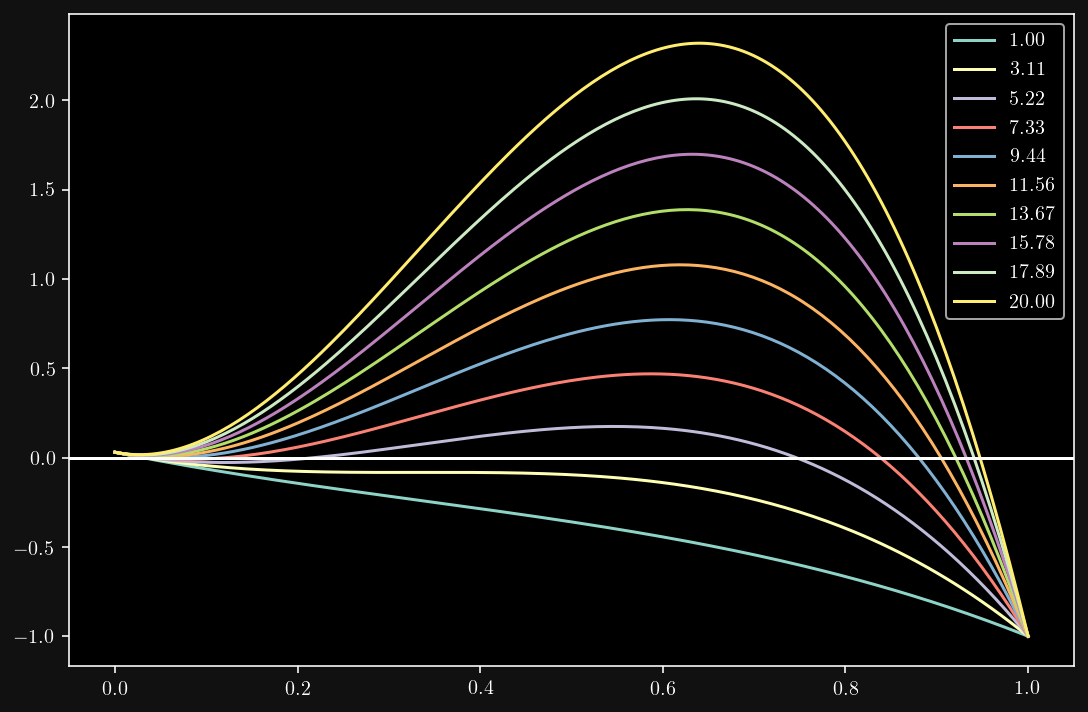

In [68]:
for mu in np.linspace(1, 20, 10):#np.logspace(-2, 2, 5):
    plt.plot(yplt, dydt(yplt, mu, 0.03), label=f'{mu:2.2f}')
plt.axhline(0)
plt.legend()
plt.show()

In [63]:
dydt(0, 1, 0.03)

0.03

In [20]:
import torch
from torch import nn
from torchvision.models import resnet50, vgg16
from torchvision import transforms
import pyro
from pyro import distributions as dist
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, JitTrace_ELBO

In [33]:
train_ims, train_labels = torch.load('ML-miscellany/data/MNIST/processed/training.pt')
test_ims, test_labels = torch.load('ML-miscellany/data/MNIST/processed/test.pt')

In [8]:
z_dim = 25

In [5]:
class Encoder(nn.Module):
    def __init__(self, z_dim, image_channels):
        super(Encoder, self).__init__()
        self.vgg16 = vgg16()
        self.vgg16.features[0] = nn.Conv2d(image_channels, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.vgg16.classifier.add_module('7',nn.ReLU(inplace=True))
        self.linear_loc = nn.Linear(in_features=1000, out_features=z_dim, bias=True)
        self.linear_scale = nn.Linear(in_features=1000, out_features=z_dim, bias=True)
        self.softplus = nn.Softplus()
    def forward(self, x):
        output =  self.vgg16(x)
        loc, scale = self.linear_loc(output), self.softplus(self.linear_scale(output))
        return loc, scale

In [9]:
# encoder = vgg16()
# encoder.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
# encoder.classifier.add_module('7',nn.ReLU(inplace=True))
# encoder.classifier.add_module('8',nn.Linear(in_features=1000, out_features=z_dim, bias=True))

In [11]:
modules = [[cc for cc in c.children()] for c in encoder.children()]
modules[1].append(encoder.avgpool)

In [6]:
class Decoder(nn.Module):
    def __init__(self, z_dim, image_channels):
        super(Decoder, self).__init__()
        self.anti_classifier = nn.Sequential(
                                nn.Linear(in_features=z_dim, out_features=1000),
                                nn.ReLU(inplace=True),
                                nn.Linear(in_features=1000, out_features=4096),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5),
                                nn.Linear(in_features=4096, out_features=4096),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5),
                                nn.Linear(in_features=4096, out_features=512*7*7),
                                nn.ReLU(inplace=True)
                               )
#reshape from [N, 25088] to [N, 512, 7, 7]
        self.anti_features = nn.Sequential(
                              nn.ConvTranspose2d(512, 512, 3, 2),
                              nn.ReLU(inplace=True),
                              nn.Conv2d(512,512, 3, 1, 1),
                              nn.ReLU(inplace=True),
                              nn.Conv2d(512, 512, 3, 1, 1),
                              nn.ReLU(inplace=True),
                              nn.Conv2d(512, 512, 3, 1, 1),
                              nn.ReLU(inplace=True),
                              nn.ConvTranspose2d(512, 512, 3, 2),
                              nn.Conv2d(512,512, 3, 1, 1),
                              nn.ReLU(inplace=True),
                              nn.Conv2d(512, 512, 3, 1, 1),
                              nn.ReLU(inplace=True),
                              nn.Conv2d(512, 256, 3, 1, 1),
                              nn.ReLU(inplace=True),
                              nn.ConvTranspose2d(256,256, 3, 2),
                              nn.Conv2d(256, 256, 3, 1, 1),
                              nn.ReLU(inplace=True),
                              nn.Conv2d(256, 256, 3, 1, 1),
                              nn.ReLU(inplace=True),
                              nn.Conv2d(256, 128, 3, 1, 1),
                              nn.ReLU(inplace=True),
                              nn.ConvTranspose2d(128,128, 3, 2),
                              nn.ReLU(inplace=True),
                              nn.ConvTranspose2d(128,64, 3, 2),
                              nn.ReLU(inplace=True),
                              nn.ConvTranspose2d(64, image_channels, 3, 2,output_padding=1)
                             )
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, z):
        out = self.anti_classifier(z)
        out = out.view((-1, 512, 7, 7))
        out = self.anti_features(out)
        out = self.sigmoid(out)
        return out

In [7]:
#from pyro VAE tutorial
# Ditched the hidden dim argument bc not relevant for this network
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=50, image_channels=1, use_cuda=False):
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, image_channels)
        self.decoder = Decoder(z_dim, image_channels)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z
            loc_img = self.decoder(z)
            # score against actual images
            #print(loc_img.shape)
            pyro.sample("obs", dist.Bernoulli(loc_img).to_event(3), obs=x)

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img

In [63]:
z_dim = 25
encoder = Encoder(z_dim)
decoder = Decoder(z_dim)

In [27]:
enc = encoder(ims)

In [29]:
out = decoder(enc[0])

In [21]:
adam = Adam({'lr':1e-3})
resize = transforms.Resize((512,512))

In [34]:
vae = VAE(2)

In [35]:
svi = SVI(vae.model, vae.guide, adam, Trace_ELBO())

In [36]:
batch = (resize(train_ims[torch.randperm(train_ims.shape[0])[:16]])/255.).unsqueeze(1).to(torch.float)

In [37]:
svi.step(batch)

2989257.0434379578

In [127]:
svi.step(batch)

2486309.193212509

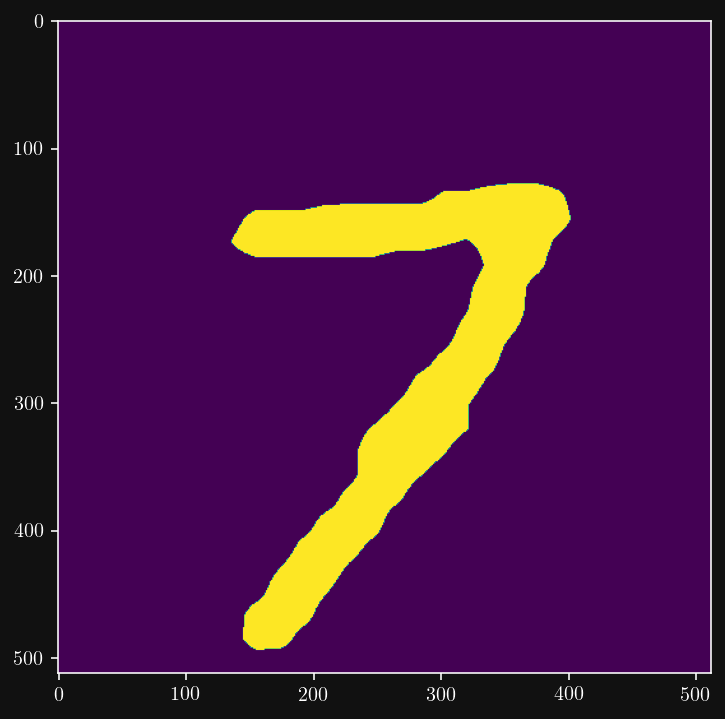

In [93]:
plt.imshow(batch[0,0]>.5)

In [ ]:
for i in range(3):
    ims = resize(train_ims[torch.randperm(train_ims.shape[0])[:16]].unsqueeze(1).to(torch.float))
    loss = svi.step(ims)
    print(loss)

In [8]:
imagenet64_glob = glob.glob('ML-miscellany/data/Imagenet64_train_part1_npz/*')

In [131]:
imagenet64_glob

['ML-miscellany/data/Imagenet64_train_part1_npz/train_data_batch_5.npz',
 'ML-miscellany/data/Imagenet64_train_part1_npz/train_data_batch_4.npz',
 'ML-miscellany/data/Imagenet64_train_part1_npz/train_data_batch_1.npz',
 'ML-miscellany/data/Imagenet64_train_part1_npz/train_data_batch_3.npz',
 'ML-miscellany/data/Imagenet64_train_part1_npz/train_data_batch_2.npz']

In [133]:
imagenet64 = np.stack([np.load(f) for f in imagenet64_glob])

In [9]:
fin = np.load(imagenet64_glob[0])

In [10]:
data = fin['data']

In [162]:
labels = fin['labels']

In [163]:
labels

array([ 37, 319, 292, ..., 792, 396, 610])

In [161]:
list(fin.keys())

['data', 'mean', 'labels']

In [155]:
rdata = data.reshape(-1, 3, 64, 64)

In [23]:
img_size = 64**2

In [24]:
imgs = np.stack([data[:,i*img_size:(i+1)*img_size] for i in range(3)], axis=-1)

In [25]:
imgs = imgs.reshape(-1, 64, 64, 3)

In [26]:
t_imgs = torch.tensor(imgs).permute(0,3,1,2)

In [27]:
resize(t_imgs[123]).permute(1, 2, 0).shape

torch.Size([512, 512, 3])

In [195]:
imgs.shape[0]

128116

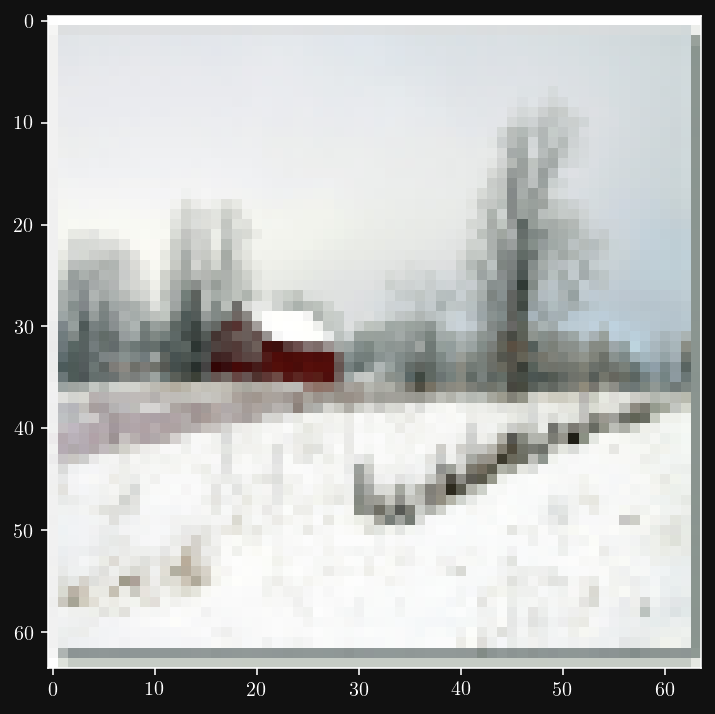

In [190]:
plt.imshow(imgs[10])

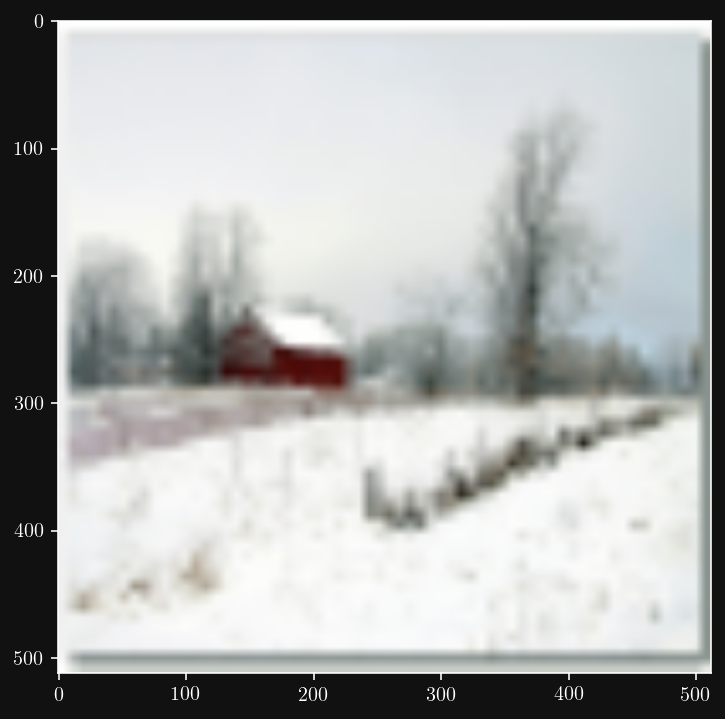

In [193]:
plt.imshow(resize(t_imgs[10]).permute(1,2,0).numpy())

In [50]:
vae_rgb = VAE(z_dim=3, image_channels=3)
adam = Adam({'lr':1e-3})

In [51]:
svi = SVI(vae_rgb.model, vae_rgb.guide, adam, Trace_ELBO())

In [38]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [42]:
t_imgs.shape

torch.Size([128116, 3, 64, 64])

In [54]:
batch = resize(t_imgs[torch.randperm(t_imgs.shape[0])[:16]])/255

In [57]:
batch.min()

tensor(0.)

In [58]:
svi.step(batch)

8846412.093322754

In [ ]:
torch.distributions.Beta()

In [144]:
for i,f in enumerate(fin.items()):
    print(f)
    if i>9: break

('data', array([[ 29,  22,  22, ...,  38,  43,  57],
       [ 46,  38,  45, ...,  73,  74,  82],
       [101,  64,  64, ...,  65,  66, 102],
       ...,
       [ 87,  84,  69, ...,  99,  98, 131],
       [203, 204, 203, ..., 246, 245, 245],
       [110, 122,  98, ...,  42,  39,  20]], dtype=uint8))
('mean', array([118.45995643, 119.56469453, 120.35390702, ..., 100.14106046,
        99.72706603,  99.14217975]))
('labels', array([ 37, 319, 292, ..., 792, 396, 610]))


In [137]:
imagenet64[0]

array(['data', 'mean', 'labels'], dtype='<U6')

In [152]:
output.shape

torch.Size([1, 64, 5, 7])

In [140]:
for m in vgg16.modules().reversed():
    print(m)

AttributeError: 'generator' object has no attribute 'reversed'

In [23]:
from torchvision import transforms

In [24]:
image_shape = (320, 480)
resize = transforms.Resize(image_shape)

In [25]:
ims = resize(train_ims[:5][:, None, ...].to(torch.float))

In [61]:
ims.shape

torch.Size([5, 1, 320, 480])

In [62]:
out = vgg16(ims)

In [63]:
features = vgg16.features(ims)

In [64]:
avgpool = vgg16.avgpool(features)

In [65]:
features.shape

torch.Size([5, 512, 10, 15])

In [66]:
convtest = nn.ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(2,2))

In [242]:
(Hin − 1)×stride[0]−2×padding[0]+dilation[0]×(kernel_size[0]−1)+output_padding[0]+1

SyntaxError: invalid character in identifier (<ipython-input-242-b1da5a5ed046>, line 1)

In [67]:
convt_out = convtest(avgpool)

In [68]:
convt_out.shape

torch.Size([5, 512, 15, 15])

In [169]:
vgg16.features[4](vgg16.features[0](ims)).shape

torch.Size([5, 64, 160, 240])

In [170]:
ims.shape

torch.Size([5, 1, 320, 480])

In [114]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
DataLoader()